In [2]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 4)

import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

#from utils import * # We've added all the functions from the last BLU to the utils.py 

In [3]:
import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

In [4]:
wf1_df = pd.read_csv('data/wf1_data.csv')  
wf2_df = pd.read_csv('data/wf2_data.csv')  
wf3_df = pd.read_csv('data/wf3_data.csv')  

In [5]:
print(wf1_df.head(3))
print(wf2_df.head(3))
print(wf3_df.head(3))

         date     wp    ws
0  2009070101  0.085  2.47
1  2009070102  0.020  2.40
2  2009070103  0.060  2.51
         date     wp    ws
0  2009070101  0.257  4.27
1  2009070102  0.178  3.65
2  2009070103  0.109  3.19
         date     wp    ws
0  2009070101  0.105  3.81
1  2009070102  0.033  3.68
2  2009070103  0.022  3.66


In [6]:
wf1_df['date'] = pd.to_datetime(wf1_df.date, format='%Y%m%d%H')
wf2_df['date'] = pd.to_datetime(wf2_df.date, format='%Y%m%d%H')
wf3_df['date'] = pd.to_datetime(wf3_df.date, format='%Y%m%d%H')

In [7]:
wf2_df

,date,wp,ws
0,2009-07-01 01:00:00,0.257,4.27
1,2009-07-01 02:00:00,0.178,3.65
2,2009-07-01 03:00:00,0.109,3.19
3,2009-07-01 04:00:00,0.079,2.90
4,2009-07-01 05:00:00,0.099,2.72
...,...,...,...
8754,2010-06-30 19:00:00,NaN,5.54
8755,2010-06-30 20:00:00,NaN,5.74
8756,2010-06-30 21:00:00,NaN,5.22
8757,2010-06-30 22:00:00,NaN,3.94


In [8]:
wf1_df = wf1_df.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True)
wf2_df = wf2_df.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True)
wf3_df = wf3_df.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True)

In [9]:
data_wf1 = wf1_df[:-24]
vtp_wf1 = wf1_df[-24:]

data_wf2 = wf2_df[:-24]
vtp_wf2 = wf2_df[-24:]

data_wf3 = wf3_df[:-24]
vtp_wf3 = wf3_df[-24:]

<AxesSubplot:xlabel='date'>

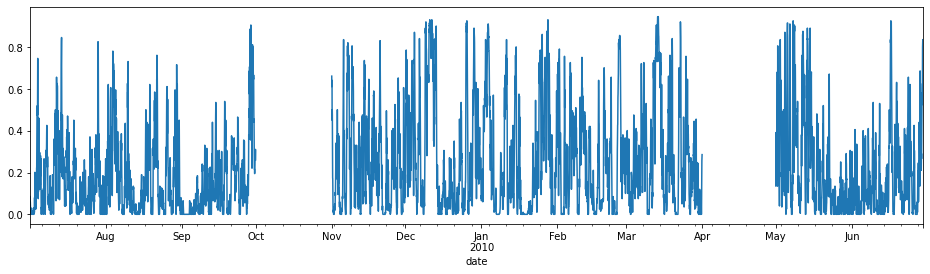

In [10]:
data_wf1.wp.plot()

<AxesSubplot:xlabel='date'>

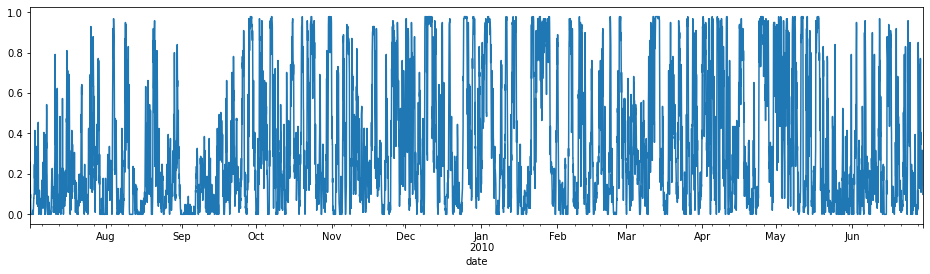

In [11]:
data_wf2.wp.plot()

<AxesSubplot:xlabel='date'>

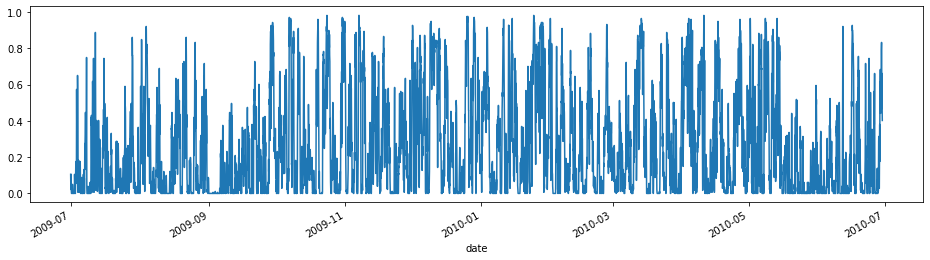

In [12]:
data_wf3.wp.plot()

In [13]:
from sklearn.impute import KNNImputer
imputer = KNNImputer() # To obtain better results we may want to have more neighbors, of course that in a real setting
                       # this is a parameter that should be tunned
    
data_imputed = imputer.fit_transform(data_wf1) # This may take a bit to run
data_wf1_imputed = pd.DataFrame(data_imputed, index=data_wf1.index, columns=data_wf1.columns)
data_wf1_imputed

,wp,ws
date,,
2009-07-01 01:00:00,0.085,2.47
2009-07-01 02:00:00,0.020,2.40
2009-07-01 03:00:00,0.060,2.51
2009-07-01 04:00:00,0.045,2.73
2009-07-01 05:00:00,0.035,2.93
...,...,...
2010-06-29 19:00:00,0.737,9.38
2010-06-29 20:00:00,0.802,9.38
2010-06-29 21:00:00,0.827,9.11


<AxesSubplot:xlabel='date'>

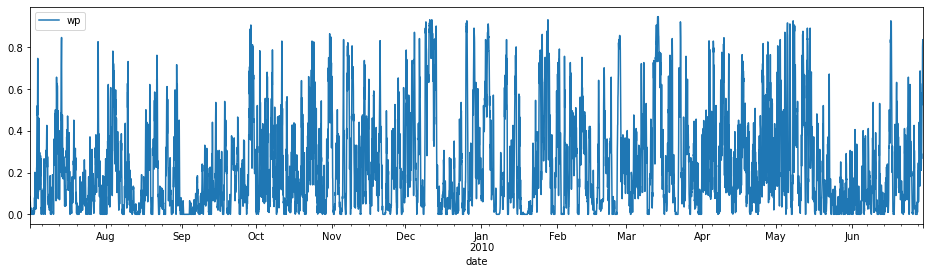

In [14]:
data_wf1_imputed = data_wf1_imputed.sort_index()
data1 = data_wf1_imputed
ws1 = data1.drop(['wp'],axis = 1)
data1 = data1.drop(['ws'],axis = 1)
data1.plot()

In [16]:
data1_train = data1[:-24]
data1_test = data1[-24:]
 
ws1_train = ws1[:-24]
ws1_test = ws1[-24:]

In [ ]:
sarimax_pipeline_exog = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=24, 
                           method='nm',
                           maxiter=1,
                           
                          )
    )
])

sarimax_pipeline_exog.fit(data1_train,ws1_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-19225.824, Time=16.69 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-19001.463, Time=0.55 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-19041.040, Time=9.62 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-19043.049, Time=9.90 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=51306.638, Time=0.37 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-19225.915, Time=13.39 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=-19222.928, Time=1.24 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=-19229.700, Time=92.73 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=-19230.093, Time=116.27 sec
 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=-19228.949, Time=104.39 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=-19230.971, Time=77.21 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=-19231.153, Time=80.19 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-19226.342, Time=14.12 sec
 ARIMA(1,1,2)(2,0,0)[24] intercept   : AIC=-19111.5

In [ ]:
plt.plot(data1_train, label='original')
plt.plot(data1_train.index, sarimax_pipeline_exog.predict_in_sample(ws1_train), label='sarimax_exog')
plt.legend()

In [ ]:
plt.plot(data1_test, label='original')
plt.plot(data1_test.index, sarimax_pipeline_exog.predict(24,ws1_test), label='sarimax_exog')
plt.legend()